### pre-processed tweet tokens to tweet labels
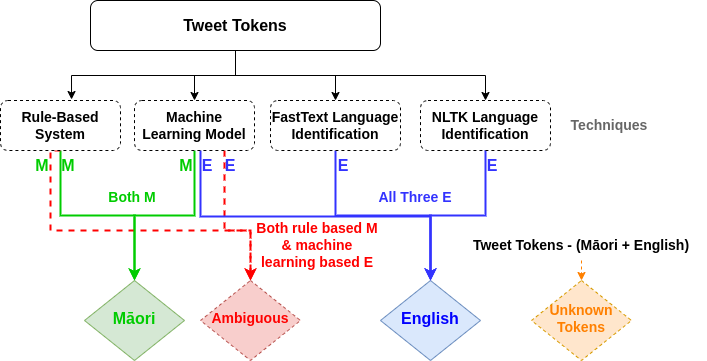

In [ ]:
import pandas as pd
import string

import os
import pandas as pd
from tensorflow import keras
import numpy as np
import tensorflow as tf
import re
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utilities import Convert, remove_punc
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)


In [2]:
df = pd.read_csv("data/data_after_preprocessing.csv")

In [3]:
df.head()

,tweet_id,user_id,modified_text,maori_words_rmt,tokens,hashtags
0,1001,x10,Living by the Moon: Te Maramataka a Te Whānau-...,"['te', 'maramataka', 'te', 'wiremu', 'tāwhai',...","['living', 'by', 'the', 'moon', 'te', 'maramat...",[]
1,1002,x11,"Ahakoa he iti, he iti pounamu tonu! Just quiet...","['ahakoa', 'he', 'iti', 'he', 'iti', 'pounamu'...","['ahakoa', 'he', 'iti', 'he', 'iti', 'pounamu'...","['#tereo', '#kiatika', '#kiarere', '#kiamāori']"
2,1003,x12,Mā UFB ka rapu tāne ahau mo ia rā Valentines #...,"['mā', 'ka', 'rapu', 'tāne', 'ahau', 'mo', 'ia...","['mā', 'ufb', 'ka', 'rapu', 'tāne', 'ahau', 'm...","['#gigatowngis', '#tweetaz', '#rvbw']"
3,1004,x13,Our beautiful punga @ Aro Valley <link>,"['punga', 'aro']","['our', 'beautiful', 'punga', 'aro', 'valley']",[]
4,1005,x14,#TeKaea tommorow Maori Television Online speci...,"['tekaea', 'maori', 'ikaroarawhiti']","['tommorow', 'maori', 'television', 'online', ...","['#tekaea', '#ikaroarawhiti']"


In [4]:
tkns = []

for ind, row in df.iterrows():
    tkn = Convert(str(row['tokens']))
    tkns.append(tkn)

df = df.drop(['tokens'],axis=1)

df['Token-list'] = tkns
    

#We make use of the bilingual fastText Skipgram pre-trained embeddings, and the Hansard data obtained from 
#### Jesin James, Vithya Yogarajan, Isabella Shields, Catherine Watson, Peter Keegan, Peter-Lucas Jones, and Keoni Mahelona. 2022. Language models for code-switch detection of te reo Maori and English in a low-resource setting. In 2022 Annual Conference of the North American Chapter of the Association for Computational Linguistics.
#The data and embeddings are available from the above research group if requested.

In [5]:
## classes are [0] for Bilingual; [1] for Maori; [2] for English (these are classes as per James et al., 2022)

model_path = "BiGRU-attention-miwiki_model2_MPW300SG.h5"
tokenizer_path = "tokenizerBiGRU-attention-miwiki_model2_MPW300SG.pickle"



In [ ]:
loaded_model = tf.keras.models.load_model(model_path)



In [7]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
Embeddng (Embedding)            (None, 250, 300)     25530900    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 250, 256)     330240      Embeddng[0][0]                   
__________________________________________________________________________________________________
dropout (Dropout)               (None, 250, 256)     0           bidirectional[0][0]              
______________________________________________________________________________________________

In [8]:
## loading tokenizer. 
with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)

In [ ]:
### best to run using a GPU machine
hname = "data/xxx.csv"
with open(hname,"w") as g:
    g.write('tweet_id;;English_words;;Maori_words_from_ML_model;;Other_words\n')
with open(hname,"a") as h:
    for ind, row in df.iterrows():
        x = row['Token-list']
        engwords = []
        otherwords = []
        maoriwords = []
        for i in x:
            j = remove_punc(i).strip()
            seq= tokenizer.texts_to_sequences([j]) 
            padded = pad_sequences(seq, maxlen=250)
            predict=loaded_model.predict(padded)
            classw=np.argmax(predict,axis=1)
            cll = int(classw[0]) ### Predicting class label based on the model. 
            if cll == 2:
                engwords.append(i) ## English
            elif cll == 1:
                maoriwords.append(i) ## Maori
            else:
                otherwords.append(i)
     #   print(row[0],engwords,maoriwords,otherwords) 
        h.write(str(row[0])+';;'+str(engwords)+';;'+str(maoriwords)+';;'+str(otherwords)+'\n')

h.close()
g.close()


In [10]:
dfL = pd.read_csv("data/xxx.csv", sep="\;\;")
dfL.head()

/home/vithya/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,tweet_id,English_words,Maori_words_from_ML_model,Other_words
0,1001,"['living', 'by', 'the', 'moon', 'a', 'ā', 'apa...","['te', 'maramataka', 'te', 'whānau', 'wiremu',...",[]
1,1002,"['he', 'he', 'just', 'quietly', 'celebrating',...","['ahakoa', 'iti', 'iti', 'pounamu', 'tonu', 'w...",[]
2,1003,"['ufb', 'valentines']","['mā', 'ka', 'rapu', 'tāne', 'ahau', 'ia', 'rā']",['mo']
3,1004,"['our', 'beautiful']","['punga', 'aro']",['valley']
4,1005,"['tommorow', 'television', 'online', 'special'...",['maori'],[]


In [11]:
dfy = df.merge(dfL,on='tweet_id',how='inner')
dfy.head()

,tweet_id,user_id,modified_text,maori_words_rmt,hashtags,Token-list,English_words,Maori_words_from_ML_model,Other_words
0,1001,x10,Living by the Moon: Te Maramataka a Te Whānau-...,"['te', 'maramataka', 'te', 'wiremu', 'tāwhai',...",[],"[living, by, the, moon, te, maramataka, a, te,...","['living', 'by', 'the', 'moon', 'a', 'ā', 'apa...","['te', 'maramataka', 'te', 'whānau', 'wiremu',...",[]
1,1002,x11,"Ahakoa he iti, he iti pounamu tonu! Just quiet...","['ahakoa', 'he', 'iti', 'he', 'iti', 'pounamu'...","['#tereo', '#kiatika', '#kiarere', '#kiamāori']","[ahakoa, he, iti, he, iti, pounamu, tonu, just...","['he', 'he', 'just', 'quietly', 'celebrating',...","['ahakoa', 'iti', 'iti', 'pounamu', 'tonu', 'w...",[]
2,1003,x12,Mā UFB ka rapu tāne ahau mo ia rā Valentines #...,"['mā', 'ka', 'rapu', 'tāne', 'ahau', 'mo', 'ia...","['#gigatowngis', '#tweetaz', '#rvbw']","[mā, ufb, ka, rapu, tāne, ahau, mo, ia, rā, va...","['ufb', 'valentines']","['mā', 'ka', 'rapu', 'tāne', 'ahau', 'ia', 'rā']",['mo']
3,1004,x13,Our beautiful punga @ Aro Valley <link>,"['punga', 'aro']",[],"[our, beautiful, punga, aro, valley]","['our', 'beautiful']","['punga', 'aro']",['valley']
4,1005,x14,#TeKaea tommorow Maori Television Online speci...,"['tekaea', 'maori', 'ikaroarawhiti']","['#tekaea', '#ikaroarawhiti']","[tommorow, maori, television, online, special,...","['tommorow', 'television', 'online', 'special'...",['maori'],[]


In [12]:
del dfL, df

In [ ]:
#!pip install fastText
#!pip install nltk

In [14]:
#https://fasttext.cc/docs/en/language-identification.html

import fasttext

class LanguageIdentification:
    """
    Class object for Language Identification
    """

    def __init__(self):
        """
        Initializing class objects
        """
        pretrained_lang_model = "data/lid.176.bin"
        self.model = fasttext.load_model(pretrained_lang_model)

    def predict_lang(self, text):
        """
        Attributes
        text: type str, the sentence for which language is to be identified
        """
        predictions = self.model.predict(text) # top 1 matching languages
        return predictions


In [17]:
from nltk.corpus import words

ENNX = []


LANGUAGE = LanguageIdentification()

for ind, row in dfy.iterrows():
    tkn = row['Token-list']
    ENN = []
    for w in tkn:  
        LANG = LANGUAGE.predict_lang(w)
        eng = LANG[0][0].split("__label__")[1]
        if eng in 'en':
            eng_word = w
            ENN.append(eng_word)
        else:
            if w in words.words():
                eng_word1 = w
                ENN.append(eng_word1)
    ENNX.append(ENN)


dfy['FastText_NLTK_English'] = ENNX  

dfy.head()


,tweet_id,user_id,modified_text,maori_words_rmt,hashtags,Token-list,English_words,Maori_words_from_ML_model,Other_words,FastText_NLTK_English
0,1001,x10,Living by the Moon: Te Maramataka a Te Whānau-...,"['te', 'maramataka', 'te', 'wiremu', 'tāwhai',...",[],"[living, by, the, moon, te, maramataka, a, te,...","['living', 'by', 'the', 'moon', 'a', 'ā', 'apa...","['te', 'maramataka', 'te', 'whānau', 'wiremu',...",[],"[living, by, the, moon, te, maramataka, a, te,..."
1,1002,x11,"Ahakoa he iti, he iti pounamu tonu! Just quiet...","['ahakoa', 'he', 'iti', 'he', 'iti', 'pounamu'...","['#tereo', '#kiatika', '#kiarere', '#kiamāori']","[ahakoa, he, iti, he, iti, pounamu, tonu, just...","['he', 'he', 'just', 'quietly', 'celebrating',...","['ahakoa', 'iti', 'iti', 'pounamu', 'tonu', 'w...",[],"[he, he, pounamu, just, quietly, celebrating, ..."
2,1003,x12,Mā UFB ka rapu tāne ahau mo ia rā Valentines #...,"['mā', 'ka', 'rapu', 'tāne', 'ahau', 'mo', 'ia...","['#gigatowngis', '#tweetaz', '#rvbw']","[mā, ufb, ka, rapu, tāne, ahau, mo, ia, rā, va...","['ufb', 'valentines']","['mā', 'ka', 'rapu', 'tāne', 'ahau', 'ia', 'rā']",['mo'],"[ka, mo]"
3,1004,x13,Our beautiful punga @ Aro Valley <link>,"['punga', 'aro']",[],"[our, beautiful, punga, aro, valley]","['our', 'beautiful']","['punga', 'aro']",['valley'],"[our, beautiful, punga, valley]"
4,1005,x14,#TeKaea tommorow Maori Television Online speci...,"['tekaea', 'maori', 'ikaroarawhiti']","['#tekaea', '#ikaroarawhiti']","[tommorow, maori, television, online, special,...","['tommorow', 'television', 'online', 'special'...",['maori'],[],"[maori, television, online, special, of, special]"


In [18]:
dfy = dfy.drop(['Other_words'],axis=1)

In [20]:
ENG = []

for ind, row in dfy.iterrows():
    first_list = row['FastText_NLTK_English']
    second_list = Convert(row['English_words'])
    eng = [i for i in first_list if i in second_list]
    en = []
    for x in eng:
        if re.search(u'[āēīōūäëöüï]',x):
            print("Error",ind) 
        else:
            en.append(x)
    ENG.append(en)

dfy['Updated_Eng_Words'] = ENG
dfy = dfy.drop(['English_words','FastText_NLTK_English'],axis=1)

dfy.head()

Error 0


,tweet_id,user_id,modified_text,maori_words_rmt,hashtags,Token-list,Maori_words_from_ML_model,Updated_Eng_Words
0,1001,x10,Living by the Moon: Te Maramataka a Te Whānau-...,"['te', 'maramataka', 'te', 'wiremu', 'tāwhai',...",[],"[living, by, the, moon, te, maramataka, a, te,...","['te', 'maramataka', 'te', 'whānau', 'wiremu',...","[living, by, the, moon, a]"
1,1002,x11,"Ahakoa he iti, he iti pounamu tonu! Just quiet...","['ahakoa', 'he', 'iti', 'he', 'iti', 'pounamu'...","['#tereo', '#kiatika', '#kiarere', '#kiamāori']","[ahakoa, he, iti, he, iti, pounamu, tonu, just...","['ahakoa', 'iti', 'iti', 'pounamu', 'tonu', 'w...","[he, he, just, quietly, celebrating, our, over..."
2,1003,x12,Mā UFB ka rapu tāne ahau mo ia rā Valentines #...,"['mā', 'ka', 'rapu', 'tāne', 'ahau', 'mo', 'ia...","['#gigatowngis', '#tweetaz', '#rvbw']","[mā, ufb, ka, rapu, tāne, ahau, mo, ia, rā, va...","['mā', 'ka', 'rapu', 'tāne', 'ahau', 'ia', 'rā']",[]
3,1004,x13,Our beautiful punga @ Aro Valley <link>,"['punga', 'aro']",[],"[our, beautiful, punga, aro, valley]","['punga', 'aro']","[our, beautiful]"
4,1005,x14,#TeKaea tommorow Maori Television Online speci...,"['tekaea', 'maori', 'ikaroarawhiti']","['#tekaea', '#ikaroarawhiti']","[tommorow, maori, television, online, special,...",['maori'],"[television, online, special, of, special]"


In [21]:
newMW = [] ## definitely Maori
Ma = []

for ind, row in dfy.iterrows():
    t_list = Convert(row['Maori_words_from_ML_model'])
    t1_list = Convert(row['maori_words_rmt'])
    list2 = row['Token-list']
    mw = []
    ma = []
    for word in t_list:
        if word in t1_list:
            mw.append(word)
    for wr in list2:
        if re.search(u'[āēīōūäëöüï]',wr):    
            ma.append(wr)
    newMW.append(mw)
    Ma.append(ma)


dfy['Definitely_Maori_words'] = newMW
dfy['To_Check_Maori_list'] = Ma

dfy = dfy.drop(['Maori_words_from_ML_model','maori_words_rmt'],axis=1)
#
dfy.head()

,tweet_id,user_id,modified_text,hashtags,Token-list,Updated_Eng_Words,Definitely_Maori_words,To_Check_Maori_list
0,1001,x10,Living by the Moon: Te Maramataka a Te Whānau-...,[],"[living, by, the, moon, te, maramataka, a, te,...","[living, by, the, moon, a]","[te, maramataka, te, wiremu, tāwhai, te, te, n...","[whānau, ā, tāwhai, whānau, ā, whakatōhea, ngāti]"
1,1002,x11,"Ahakoa he iti, he iti pounamu tonu! Just quiet...","['#tereo', '#kiatika', '#kiarere', '#kiamāori']","[ahakoa, he, iti, he, iti, pounamu, tonu, just...","[he, he, just, quietly, celebrating, our, over...","[ahakoa, iti, iti, pounamu, tonu, whanaunga, t...",[māori]
2,1003,x12,Mā UFB ka rapu tāne ahau mo ia rā Valentines #...,"['#gigatowngis', '#tweetaz', '#rvbw']","[mā, ufb, ka, rapu, tāne, ahau, mo, ia, rā, va...",[],"[mā, ka, rapu, tāne, ahau, ia, rā]","[mā, tāne, rā]"
3,1004,x13,Our beautiful punga @ Aro Valley <link>,[],"[our, beautiful, punga, aro, valley]","[our, beautiful]","[punga, aro]",[]
4,1005,x14,#TeKaea tommorow Maori Television Online speci...,"['#tekaea', '#ikaroarawhiti']","[tommorow, maori, television, online, special,...","[television, online, special, of, special]",[maori],[]


In [22]:
MAO = []
for ind, row in dfy.iterrows():
    m_list = row['Definitely_Maori_words']
    c_list = row['To_Check_Maori_list']
    mww = []
    for word in c_list:
        if word not in m_list:
            mww.append(word)
    MAO.append(mww)

dfy['Maori_words_add'] = MAO
dfy['Maori_Words_Updated'] = dfy['Definitely_Maori_words'] + dfy['Maori_words_add']

dfy = dfy.drop(['To_Check_Maori_list','Definitely_Maori_words','Maori_words_add'],axis=1)
#
dfy.head()

,tweet_id,user_id,modified_text,hashtags,Token-list,Updated_Eng_Words,Maori_Words_Updated
0,1001,x10,Living by the Moon: Te Maramataka a Te Whānau-...,[],"[living, by, the, moon, te, maramataka, a, te,...","[living, by, the, moon, a]","[te, maramataka, te, wiremu, tāwhai, te, te, n..."
1,1002,x11,"Ahakoa he iti, he iti pounamu tonu! Just quiet...","['#tereo', '#kiatika', '#kiarere', '#kiamāori']","[ahakoa, he, iti, he, iti, pounamu, tonu, just...","[he, he, just, quietly, celebrating, our, over...","[ahakoa, iti, iti, pounamu, tonu, whanaunga, t..."
2,1003,x12,Mā UFB ka rapu tāne ahau mo ia rā Valentines #...,"['#gigatowngis', '#tweetaz', '#rvbw']","[mā, ufb, ka, rapu, tāne, ahau, mo, ia, rā, va...",[],"[mā, ka, rapu, tāne, ahau, ia, rā]"
3,1004,x13,Our beautiful punga @ Aro Valley <link>,[],"[our, beautiful, punga, aro, valley]","[our, beautiful]","[punga, aro]"
4,1005,x14,#TeKaea tommorow Maori Television Online speci...,"['#tekaea', '#ikaroarawhiti']","[tommorow, maori, television, online, special,...","[television, online, special, of, special]",[maori]


In [23]:
MAO = []
EW = []
AMB = []
UNK = []

from collections import Counter

count = 0

for ind, row in dfy.iterrows():
    mao = row['Maori_Words_Updated']
    eng = row['Updated_Eng_Words']
    tokens = row['Token-list']
    total_words = mao + eng
    common = list((Counter(mao) & Counter(eng)).elements())
    mao_u = [x for x in mao if x not in common]
    eng_u = [x for x in eng if x not in common]
    unk = list((Counter(tokens)-Counter(total_words)).elements())
    MAO.append(mao_u)
    EW.append(eng_u)
    AMB.append(common)
    UNK.append(unk)
    if len(common) !=0:
        count = count + 1

dfy['Amb_words'] = AMB
dfy['Unk_list'] = UNK
dfy['Maori_updated'] = MAO
dfy['Eng_updated'] = EW
dfy = dfy.drop(['Maori_Words_Updated','Updated_Eng_Words'],axis=1)
print(count)
dfy.head()

0


,tweet_id,user_id,modified_text,hashtags,Token-list,Amb_words,Unk_list,Maori_updated,Eng_updated
0,1001,x10,Living by the Moon: Te Maramataka a Te Whānau-...,[],"[living, by, the, moon, te, maramataka, a, te,...",[],"[apanui, apanui]","[te, maramataka, te, wiremu, tāwhai, te, te, n...","[living, by, the, moon, a]"
1,1002,x11,"Ahakoa he iti, he iti pounamu tonu! Just quiet...","['#tereo', '#kiatika', '#kiarere', '#kiamāori']","[ahakoa, he, iti, he, iti, pounamu, tonu, just...",[],[using],"[ahakoa, iti, iti, pounamu, tonu, whanaunga, t...","[he, he, just, quietly, celebrating, our, over..."
2,1003,x12,Mā UFB ka rapu tāne ahau mo ia rā Valentines #...,"['#gigatowngis', '#tweetaz', '#rvbw']","[mā, ufb, ka, rapu, tāne, ahau, mo, ia, rā, va...",[],"[ufb, mo, valentines]","[mā, ka, rapu, tāne, ahau, ia, rā]",[]
3,1004,x13,Our beautiful punga @ Aro Valley <link>,[],"[our, beautiful, punga, aro, valley]",[],[valley],"[punga, aro]","[our, beautiful]"
4,1005,x14,#TeKaea tommorow Maori Television Online speci...,"['#tekaea', '#ikaroarawhiti']","[tommorow, maori, television, online, special,...",[],[tommorow],[maori],"[television, online, special, of, special]"


In [24]:
dfy.to_csv("data/data_after_step1.csv",index=False)